In [321]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
import plotly.express as px
import json
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from segregation.singlegroup import absolute_clustering, dissim, interaction,absolute_concentration
import geopandas as gpd
import plotly.io as pio
from shapely.geometry import Point, MultiPoint
from scipy.spatial.distance import cdist
from shapely.ops import transform
from functools import partial
import pyproj

### 1. Immigrant and overall population in census tracts

In [322]:
#Read all years
directory = './data_madrid/residents_by_cob/ine/'


file_names = os.listdir(directory)
csv_files = [file for file in file_names if file.endswith('.csv')]

dfs = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path,sep='\t',thousands=r'.')
    df['year'] = file.replace('.csv', '')
    dfs.append(df)

# Concatenate all DataFrames
big_df = pd.concat(dfs, ignore_index=True)

In [323]:
#We don't care about gender and grand total
big_df=big_df[(big_df.Sexo=='Ambos Sexos') & (big_df['Sección']!='TOTAL')]
big_df=big_df.drop('Sexo',axis=1)

In [324]:
#Add total census population as a different column
census_pop = big_df[big_df['País de nacimiento']=='Total Población']
census_pop=census_pop.drop('País de nacimiento',axis=1).rename(columns={'Total':'census_total_pob'})
big_df=big_df.merge(census_pop, on=['Sección','year'], how='left')
big_df=big_df[big_df['País de nacimiento']!='Total Población']

In [325]:
#Column names
big_df.columns=['cusec','cob','population','year','census_total_pop']
big_df=big_df[['year','cusec','cob','population','census_total_pop']]

In [326]:
big_df.population=big_df.population.astype(int)
big_df.census_total_pop=big_df.census_total_pop.astype(int)

In [327]:
#Make corrections
big_df.cob=big_df.cob.replace({'República Dominicana':'Rep. Dominicana'})

In [328]:
big_df.cusec=big_df.cusec.astype('int64')

In [329]:
#Crosswalk extracted from the CUSECS shapefile
crosswalk=pd.read_csv('./data/geography/census_tracts_muns_districts_madrid.csv')
crosswalk=crosswalk[~crosswalk.CUSEC.isin([2807908002,2807908004,2807908130,2807908129,2807909072,2807919001,2807918045,2807918057,2807919052,2807908001,2807908003,2807921015])]

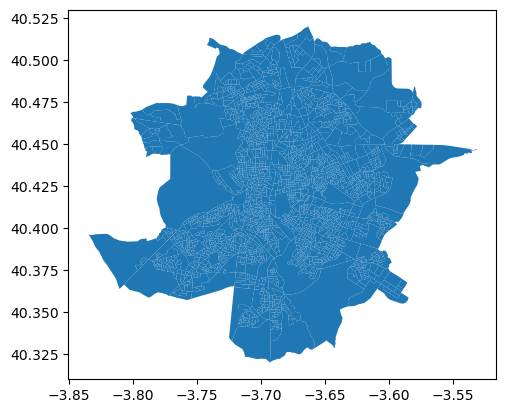

In [330]:
gdf = gpd.read_file("./data/geography/cusecs/comarca_reduced_madrid.shp", encoding='utf-8')
gdf.CUSEC=gdf.CUSEC.astype('int64')
gdf=gdf.merge(crosswalk, on='CUSEC', how='inner')
gdf.plot()
plt.show()

In [331]:
#Number of CUSECS in AMB
len(crosswalk)

2431

In [332]:
comarca=big_df.merge(crosswalk, left_on='cusec',right_on='CUSEC',how='inner')

In [333]:
#Choose the 5 countries as in the BCN analysis
top20=['Ecuador', 'Perú', 'Marruecos', 'China', 'Italia']
comarca=comarca[comarca.cob.isin(top20)]

In [334]:
len(comarca)

12155

### 2. Mean Income

In [335]:
renta = pd.read_csv('./data_madrid/renta_media/renta_media_2021.csv',sep='\t', encoding='latin-1',thousands=r'.')

In [336]:
renta=renta[~renta.Secciones.isna()]

In [337]:
#Extract the numbers from Secciones
renta['cusec']=renta.Secciones.str[:10]
renta=renta[['cusec','Total']].rename(columns={'Total':'demog_avg_income'})
renta.cusec=renta.cusec.astype('int64')

In [338]:
comarca=comarca.merge(renta, on='cusec', how='left')

### 3. Neighborhood demographics

In [339]:
demografia = pd.read_csv('./data_madrid/demografia_secciones/demografia_secciones_2021.csv', encoding='latin-1')

In [340]:
#Add cusec based on the 5 columns
demografia['cusec'] = (demografia.cpro.astype(str).apply(lambda x: x.zfill(2)) +
          demografia.cmun.astype(str).apply(lambda x: x.zfill(3)) +
          demografia.dist.astype(str).apply(lambda x: x.zfill(2)) +
          demografia.secc.astype(str).apply(lambda x: x.zfill(3)))

In [341]:
#Highligh interesting variables, using the variables description file
#When the percentages add up to 100%, we can leave one category out (e.g. Males)
demografia['demog_female']=demografia['t2_1']
demografia['demog_mean_age']=demografia['t3_1']
demografia['demog_age_16_64']=demografia['t4_2']
demografia['demog_age_64plus']=demografia['t4_3']
demografia['demog_uni_degree']=demografia['t9_1']
demografia['demog_unemployed']=demografia['t10_1']
demografia['demog_employed']=demografia['t11_1']
demografia['demog_retired']=demografia['t14_1']
demografia['demog_student']=demografia['t16_1']
demografia['demog_married']=demografia['t17_2']
demografia['housing_total_stock']=demografia['t18_1']
   #Housing variables: make it percentage
demografia['housing_owned']=demografia['t20_1']/demografia['t18_1']
demografia['housing_rented']=demografia['t20_2']/demografia['t18_1']
   #HH variables: make it percentage
demografia['demog_hh_1p']=demografia['t22_1']/demografia['t21_1']
demografia['demog_hh_3p']=demografia['t22_3']/demografia['t21_1']
demografia['demog_hh_4p']=demografia['t22_4']/demografia['t21_1']
demografia['demog_hh_5p+']=demografia['t22_5']/demografia['t21_1']

In [342]:
demografia=demografia[['cusec', 'demog_female', 'demog_mean_age', 'demog_age_16_64', 'demog_age_64plus',
    'demog_uni_degree', 'demog_unemployed', 'demog_employed', 'demog_retired',
    'demog_student', 'demog_married', 'housing_total_stock', 'housing_owned',
    'housing_rented', 'demog_hh_1p', 'demog_hh_3p', 'demog_hh_4p', 'demog_hh_5p+']]

In [343]:
demografia.head()

,cusec,demog_female,demog_mean_age,demog_age_16_64,demog_age_64plus,demog_uni_degree,demog_unemployed,demog_employed,demog_retired,demog_student,demog_married,housing_total_stock,housing_owned,housing_rented,demog_hh_1p,demog_hh_3p,demog_hh_4p,demog_hh_5p+
0,0400101001,0.4857,49.4994,0.6008,0.2944,0.2163,0.1951,0.3768,0.2899,0.0629,0.4524,1076.0,0.366171,0.074349,0.350352,0.158451,0.128521,0.042254
1,0400201001,0.4719,49.4636,0.6287,0.2822,0.1812,0.2052,0.3614,0.2754,0.0571,0.4678,921.0,0.465798,0.096634,0.413379,0.159520,0.114923,0.029160
2,0400301001,0.5086,45.0789,0.6789,0.2002,0.2356,0.1576,0.4686,0.1728,0.0903,0.4315,395.0,0.648101,0.073418,0.220447,0.204473,0.182109,0.118211
3,0400301002,0.5014,40.2112,0.6912,0.1297,0.2230,0.1251,0.5451,0.1224,0.0869,0.4340,789.0,0.678074,0.048162,0.190096,0.222045,0.246006,0.092652
4,0400301003,0.5087,38.1048,0.7051,0.1065,0.1720,0.1439,0.5805,0.1036,0.0832,0.3960,1117.0,0.627574,0.073411,0.261324,0.217189,0.202091,0.069686


In [344]:
demografia.cusec = demografia.cusec.astype('int64')

In [345]:
comarca=comarca.merge(demografia, on='cusec', how='left')

### 4. Housing market

This is going to work differently for Madrid, we only have district level data

In [346]:
hab1 = pd.read_excel('./data_madrid/censo_habitatge/tipo_y_ano_construccion_2021.xls',sheet_name='Total viviendas',skiprows=4)
hab2 = pd.read_excel('./data_madrid/censo_habitatge/tipo_y_numero_plantas_2021.xls',sheet_name='Total viviendas',skiprows=5)
hab3 = pd.read_excel('./data_madrid/censo_habitatge/tipo_y_superficie_2021.xls',sheet_name='Total viviendas',skiprows=4)

In [347]:
hab1=hab1[(~hab1.Total.isna()) & (hab1.Distritos !='Ciudad de Madrid')].reset_index(drop=True)
hab2=hab2[(~hab2.Total.isna()) & (hab2['Unnamed: 0'] !='Ciudad de Madrid')].reset_index(drop=True)
hab3=hab3[(~hab3.Total.isna())  & (hab3.Distritos!='Ciudad de Madrid')].reset_index(drop=True)

In [348]:
hab1['district']=hab1.Distritos.str[:2].astype(int)
hab2['district']=hab2['Unnamed: 0'] .str[:2].astype(int)
hab3['district']=hab3.Distritos.str[:2].astype(int)

In [349]:
# Define a function to clean up the asterisks and convert to integers
def clean_and_convert(value):
    if isinstance(value, str) and '*' in value:
        return int(value.replace('*', ''))
    else:
        return int(value)

# Apply the function to each cell in the DataFrame
hab1.iloc[:,1:] = hab1.iloc[:,1:].applymap(clean_and_convert)
hab2.iloc[:,1:] = hab2.iloc[:,1:].applymap(clean_and_convert)
hab3.iloc[:,1:] = hab3.iloc[:,1:].applymap(clean_and_convert)

In [350]:
#Construction year
   #Relaticve frequency only over those with age
hab1['Total']=hab1['Total']-hab1['No consta']
hab1['housing_constr_bef_1940']=(hab1['Antes de 1900'] + hab1['1900-1920'] + hab1['1921-1940'])/hab1.Total
hab1['housing_constr_aft_2000']=hab1[['2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011']].sum(axis=1)/hab1.Total
hab1=hab1[['district','housing_constr_bef_1940','housing_constr_aft_2000']]

In [351]:
#Number of floors
hab2['Total']=hab2['Total']-hab2['No consta']
hab2['housing_floor_7_plus']=(hab2[7]+hab2[8]+hab2[9]+hab2['10 o más'])/hab2.Total
hab2['housing_floor_1']=(hab2[1])/hab2.Total
hab2=hab2[['district','housing_floor_1','housing_floor_7_plus']]

In [352]:
#Housing size
hab3['housing_m2_und_60']=(hab3['Hasta 30 m2']+hab3['De 30 a 45 m2']+hab3['De 46 a 60 m2'])/hab3.Total
hab3['housing_m2_ovr_120']=(hab3['De 121 a 150 m2']+hab3['De 151 a 180 m2']+hab3['Más de 180 m2'])/hab3.Total
hab3=hab3[['district','housing_m2_und_60','housing_m2_ovr_120']]

In [353]:
comarca=comarca.merge(hab1, how='left', left_on='CDIS',right_on='district').drop('district',axis=1)
comarca=comarca.merge(hab2, how='left', left_on='CDIS',right_on='district').drop('district',axis=1)
comarca=comarca.merge(hab3, how='left', left_on='CDIS',right_on='district').drop('district',axis=1)

### 5. Median rent

In [355]:
# Read the shapefile
mitma = gpd.read_file("./data/mitma_alquiler/Secciones_alq_2021.shp")

In [356]:
#Two types for statistics: Colectiva vs Unifamiliar: (= piso vs casa)
#Logic we apply: go for Colectiva, otherwise Unifamiliar
mitma['housing_rent_median']=np.where(mitma.Cuantía_m!=0, mitma.Cuantía_m, mitma.Cuantía_1)
mitma['housing_rent_m2_median']=np.where(mitma.Renta_Medi!=0, mitma.Renta_Medi, mitma.Renta_Me_1)
mitma=mitma.rename(columns={'CUSEC':'cusec'})
mitma=mitma[['cusec','housing_rent_median','housing_rent_m2_median']]

In [357]:
mitma.cusec=mitma.cusec.astype('int64')

In [358]:
comarca=comarca.merge(mitma, on='cusec', how='left')

Missing values

In [359]:
#Zeros should be missing
comarca.housing_rent_median=comarca.housing_rent_median.replace({0:np.nan})
comarca.housing_rent_m2_median=comarca.housing_rent_m2_median.replace({0:np.nan})

In [360]:
#88 missing or 0 values
comarca[(comarca.housing_rent_median.isna())].cusec.unique()

array([2807902107, 2807902108, 2807902109, 2807902110, 2807902111,
       2807902112, 2807903039, 2807903100, 2807904131, 2807905103,
       2807905104, 2807907134, 2807908177, 2807908178, 2807908179,
       2807908180, 2807908181, 2807908182, 2807908183, 2807908184,
       2807908185, 2807908186, 2807908187, 2807908188, 2807909089,
       2807909090, 2807909091, 2807909092, 2807910157, 2807910158,
       2807910159, 2807910221, 2807911195, 2807911196, 2807911197,
       2807911198, 2807912109, 2807913003, 2807913004, 2807913006,
       2807913007, 2807913011, 2807913217, 2807914093, 2807914094,
       2807914095, 2807916071, 2807916072, 2807916121, 2807916122,
       2807916123, 2807916124, 2807916125, 2807916126, 2807916127,
       2807916128, 2807916129, 2807917021, 2807917098, 2807917113,
       2807917114, 2807917115, 2807917116, 2807918026, 2807918059,
       2807918060, 2807918061, 2807918062, 2807918063, 2807918064,
       2807918065, 2807918066, 2807918067, 2807918068, 2807919

In [361]:
comarca['district']=(comarca['CUMUN'].astype(str) + comarca['CDIS'].astype(str)).astype(int)

In [362]:
#Fill in with the district means
comarca.housing_rent_median = comarca.groupby("district")["housing_rent_median"].transform(lambda x: x.fillna(x.mean()))
comarca.housing_rent_m2_median = comarca.groupby("district")["housing_rent_m2_median"].transform(lambda x: x.fillna(x.mean()))

In [363]:
comarca[(comarca.housing_rent_median.isna())].cusec.unique()

array([], dtype=int64)

In [364]:
comarca=comarca.drop('district',axis=1)

### 6. Public Transportation

 1. Distance to transportation stops

In [365]:
#Metro
tmb = pd.read_csv('./data_madrid/transporte/metro_stops.csv')

#Need to convert UTM to WGS84
from pyproj import Proj, transform
tmb['UTM X']=tmb['X'].astype(float)
tmb['UTM Y']=tmb['Y'].astype(float)
# Define the UTM zone for Spain, Barcelona
utm_zone = 30
# Create a PyProj transformer for UTM to WGS84 (latitude and longitude)
utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
# Function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(utm_x, utm_y):
    lon, lat = utm_proj(utm_x, utm_y, inverse=True)
    return lat, lon
tmb['latlon'] = tmb.apply(lambda row: utm_to_latlon(row['UTM X'], row['UTM Y']), axis=1)
tmb[['latitude', 'longitude']] =tmb['latlon'].apply(lambda x: pd.Series({'latitude': x[0], 'longitude': x[1]}))
tmb = tmb.drop(columns=['latlon'])

In [366]:
#Bus
bus = pd.read_excel('./data_madrid/transporte/bus_stops.xlsx',decimal=',')

#Need to convert UTM to WGS84
from pyproj import Proj, transform
bus['UTM X']=bus['PosxNode'].astype(float)
bus['UTM Y']=bus['PosyNode'].astype(float)
# Define the UTM zone for Spain, Barcelona
utm_zone = 30
# Create a PyProj transformer for UTM to WGS84 (latitude and longitude)
utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
# Function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(utm_x, utm_y):
    lon, lat = utm_proj(utm_x, utm_y, inverse=True)
    return lat, lon
bus['latlon'] = bus.apply(lambda row: utm_to_latlon(row['UTM X'], row['UTM Y']), axis=1)
bus[['latitude', 'longitude']] =bus['latlon'].apply(lambda x: pd.Series({'latitude': x[0], 'longitude': x[1]}))
bus = bus.drop(columns=['latlon'])

In [367]:
#Renfe
renfe = pd.read_csv('./data_madrid/transporte/rodalies_stops.csv',sep=';',decimal=',')

In [368]:
#Read map
cusecs = gpd.read_file('./data/geography/cusecs/comarca_reduced_madrid.shp')

In [369]:
#Create coordinates
points_metro = gpd.GeoDataFrame(geometry=gpd.points_from_xy(tmb['longitude'], tmb['latitude']))
points_bus = gpd.GeoDataFrame(geometry=gpd.points_from_xy(bus['longitude'], bus['latitude']))
points_tren = gpd.GeoDataFrame(geometry=gpd.points_from_xy(renfe['LONGITUD'], renfe['LATITUD']))

In [370]:
#Project to same CRS
cusecs = cusecs.set_crs(epsg=4326)
points_metro = points_metro.set_crs(epsg=4326)
points_bus = points_bus.set_crs(epsg=4326)
points_tren = points_tren.set_crs(epsg=4326)

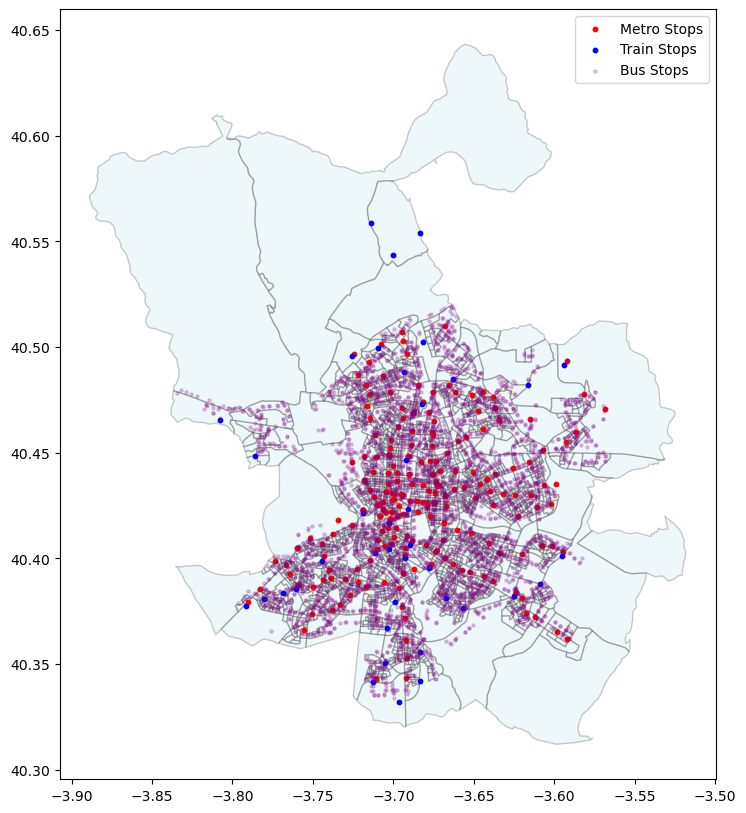

In [371]:
#Spatial joins
joined_metro = gpd.sjoin(points_metro, cusecs, how='left', op='within')
joined_bus = gpd.sjoin(points_bus, cusecs, how='left', op='within')
joined_tren = gpd.sjoin(points_tren, cusecs, how='left', op='within')

fig, ax = plt.subplots(figsize=(10, 10))
cusecs.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.2, label='Original Districts')
joined_metro[~joined_metro.CUSEC.isna()].plot(ax=ax, color='red', markersize=10, label='Metro Stops')
joined_tren[~joined_tren.CUSEC.isna()].plot(ax=ax, color='blue', markersize=10, label='Train Stops')
joined_bus[~joined_bus.CUSEC.isna()].plot(ax=ax, color='purple', markersize=5, alpha=0.2, label='Bus Stops')


ax.legend()
plt.show()

In [372]:
#### Select 10 random points in each CUSEC
#### Find distance to nearest point
#### Average the distances

'''
from shapely.geometry import Point, MultiPoint

#Changed this to 30N
cusecs = cusecs.to_crs('EPSG:32630')

def generate_random_points(geometry):
    minx, miny, maxx, maxy = geometry.bounds
    points = []

    
    while len(points)<10:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        point = Point(x, y)
        if point.within(geometry):
            points.append(point)

    return points

cusecs['random_points'] = cusecs['geometry'].apply(generate_random_points)

import pickle
# Save GeoDataFrame to pickle file
with open('./data/geography/cusecs/comarca_with_random_points_madrid.pkl', 'wb') as f:
    pickle.dump(cusecs, f)

'''


"\nfrom shapely.geometry import Point, MultiPoint\n\n#Changed this to 30N\ncusecs = cusecs.to_crs('EPSG:32630')\n\ndef generate_random_points(geometry):\n    minx, miny, maxx, maxy = geometry.bounds\n    points = []\n\n    \n    while len(points)<10:\n        x = np.random.uniform(minx, maxx)\n        y = np.random.uniform(miny, maxy)\n        point = Point(x, y)\n        if point.within(geometry):\n            points.append(point)\n\n    return points\n\ncusecs['random_points'] = cusecs['geometry'].apply(generate_random_points)\n\nimport pickle\n# Save GeoDataFrame to pickle file\nwith open('./data/geography/cusecs/comarca_with_random_points_madrid.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n\n"

In [373]:
# We generated 10 points for each cusec, now load it
import pickle
with open('./data/geography/cusecs/comarca_with_random_points_madrid.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [374]:
points_metro = points_metro.to_crs('EPSG:32630')
points_bus = points_bus.to_crs('EPSG:32630')
points_tren = points_tren.to_crs('EPSG:32630')

In [375]:
# Function to calculate distance to the closest point
'''
def closest_distance_to_points_metro(point_list, points_df):
    point_coords = np.array([point.xy for point in point_list])
    points_metro_coords = np.array([point.xy for point in points_df['geometry']])

    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))
    #For each of the 10 points, find the shortest distance
    min_distances = [min(point) for point in all_distances]

    #Avg
    return np.mean(min_distances)

# Apply the function
cusecs['neigh_closest_metro'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_metro))
cusecs['neigh_closest_bus'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_bus))
cusecs['neigh_closest_train'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_tren))

with open('./data/geography/cusecs/comarca_with_random_points_distances_madrid.pkl', 'wb') as f:
    pickle.dump(cusecs, f)
'''

"\ndef closest_distance_to_points_metro(point_list, points_df):\n    point_coords = np.array([point.xy for point in point_list])\n    points_metro_coords = np.array([point.xy for point in points_df['geometry']])\n\n    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))\n    #For each of the 10 points, find the shortest distance\n    min_distances = [min(point) for point in all_distances]\n\n    #Avg\n    return np.mean(min_distances)\n\n# Apply the function\ncusecs['neigh_closest_metro'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_metro))\ncusecs['neigh_closest_bus'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_bus))\ncusecs['neigh_closest_train'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_tren))\n\nwith open('./data/geography/cusecs/comarca_with_random_points_distances_madrid.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n"

In [376]:
# We got the mean distance to the closest stop
with open('./data/geography/cusecs/comarca_with_random_points_distances_madrid.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [377]:
cusecs=cusecs[['CUSEC','neigh_closest_metro','neigh_closest_bus','neigh_closest_train']].rename(columns={'CUSEC':'cusec'})

In [378]:
cusecs.cusec=cusecs.cusec.astype('int64')

In [379]:
comarca=comarca.merge(cusecs, on='cusec',  how='left')

In [380]:
comarca

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,housing_constr_aft_2000,housing_floor_1,housing_floor_7_plus,housing_m2_und_60,housing_m2_ovr_120,housing_rent_median,housing_rent_m2_median,neigh_closest_metro,neigh_closest_bus,neigh_closest_train
0,2021,2807901001,Italia,18,1167,2807901001,28079,1,1,79,...,0.042157,0.000173,0.131192,0.537234,0.077518,1000.00000,14.472955,481.333522,155.631306,527.427829
1,2021,2807901001,Marruecos,9,1167,2807901001,28079,1,1,79,...,0.042157,0.000173,0.131192,0.537234,0.077518,1000.00000,14.472955,481.333522,155.631306,527.427829
2,2021,2807901001,Ecuador,11,1167,2807901001,28079,1,1,79,...,0.042157,0.000173,0.131192,0.537234,0.077518,1000.00000,14.472955,481.333522,155.631306,527.427829
3,2021,2807901001,Perú,13,1167,2807901001,28079,1,1,79,...,0.042157,0.000173,0.131192,0.537234,0.077518,1000.00000,14.472955,481.333522,155.631306,527.427829
4,2021,2807901001,China,16,1167,2807901001,28079,1,1,79,...,0.042157,0.000173,0.131192,0.537234,0.077518,1000.00000,14.472955,481.333522,155.631306,527.427829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12150,2021,2807921033,Italia,8,2742,2807921033,28079,33,21,79,...,0.205057,0.026264,0.21944,0.21701,0.10907,882.62542,11.360825,1197.266816,451.532306,955.393558
12151,2021,2807921033,Marruecos,43,2742,2807921033,28079,33,21,79,...,0.205057,0.026264,0.21944,0.21701,0.10907,882.62542,11.360825,1197.266816,451.532306,955.393558
12152,2021,2807921033,Ecuador,51,2742,2807921033,28079,33,21,79,...,0.205057,0.026264,0.21944,0.21701,0.10907,882.62542,11.360825,1197.266816,451.532306,955.393558
12153,2021,2807921033,Perú,23,2742,2807921033,28079,33,21,79,...,0.205057,0.026264,0.21944,0.21701,0.10907,882.62542,11.360825,1197.266816,451.532306,955.393558


### 7. Schools

In [381]:
escuelas=pd.read_csv('./data_madrid/escuelas/escuelas_direccion.csv', encoding='latin-1',sep=';' )

In [382]:
#We actually have the coordinates
#This is whole comunidad de madrid, that's why it's so many eh
print(len(escuelas), len(escuelas[~escuelas.direccion_coor_x.isna()]))

4038 4010


In [383]:
#need to convert UTM to WGS84
from pyproj import Proj, transform
escuelas['UTM X']=escuelas['direccion_coor_x'].astype(float)
escuelas['UTM Y']=escuelas['direccion_coor_y'].astype(float)
# Define the UTM zone for Spain, Madrid
utm_zone = 30
# Create a PyProj transformer for UTM to WGS84 (latitude and longitude)
utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
# Function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(utm_x, utm_y):
    lon, lat = utm_proj(utm_x, utm_y, inverse=True)
    return lat, lon
escuelas['latlon'] = escuelas.apply(lambda row: utm_to_latlon(row['UTM X'], row['UTM Y']), axis=1)
escuelas[['lat', 'long']] =escuelas['latlon'].apply(lambda x: pd.Series({'latitude': x[0], 'longitude': x[1]}))
escuelas = escuelas.drop(columns=['latlon'])

In [384]:
escuelas=escuelas[~escuelas.lat.isna()]

In [385]:
escuelas.tail(3)

,centro_codigo,centro_nombre,centro_tipo_codigo,centro_tipo_desc_abreviada,centro_tipo_descripcion,centro_titularidad,centro_titular,dat_codigo,dat_nombre,direccion_via_tipo,...,contacto_telefono4,contacto_fax,contacto_web,contacto_email1,direccion_coor_x,direccion_coor_y,UTM X,UTM Y,lat,long
4034,28701263,GETAFE,38,CET,CENTRO EDUCATIVO-TERAPÉUTICO,PÚBLICO,COMUNIDAD DE MADRID,2,Madrid-Sur,AVDA,...,NaN,NaN,http://www.educa.madrid.org/cet.getafe,cet.getafe@educa.madrid.org,439147.0,4462377.0,439147.0,4462377.0,40.309692,-3.716143
4035,28701275,CENTRO REGIONAL DE ENRIQUECIMIENTO EDUCATIVO P...,225,CREACIM,CENTRO REGIONAL DE ENRIQUECIMIENTO EDUCATIVO P...,PÚBLICO,COMUNIDAD DE MADRID,5,Madrid-Capital,AVDA,...,NaN,NaN,NaN,NaN,448077.0,4475099.0,448077.0,4475099.0,40.424904,-3.612094
4036,28701287,MODESTO LAFUENTE,38,CET,CENTRO EDUCATIVO-TERAPÉUTICO,PÚBLICO,COMUNIDAD DE MADRID,5,Madrid-Capital,CALLE,...,NaN,NaN,NaN,NaN,440949.0,4476842.0,440949.0,4476842.0,40.440130,-3.696278


Distance to closest school

In [386]:
#Read map
cusecs = gpd.read_file('./data/geography/cusecs/comarca_reduced_madrid.shp')

In [387]:
cusecs

,CUSEC,CUMUN,CSEC,CDIS,CMUN,CPRO,CCA,CUDIS,CLAU2,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,NMUN,area,geometry
0,2807901001,28079,001,01,079,28,13,2807901,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.71113 40.42075, -3.71176 40.42067..."
1,2807901002,28079,002,01,079,28,13,2807901,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.71015 40.42294, -3.71030 40.42282..."
2,2807901003,28079,003,01,079,28,13,2807901,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.70794 40.42153, -3.70779 40.42144..."
3,2807901004,28079,004,01,079,28,13,2807901,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.71025 40.42079, -3.71020 40.42073..."
4,2807901006,28079,006,01,079,28,13,2807901,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.70815 40.41906, -3.70818 40.41895..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,2807921029,28079,029,21,079,28,13,2807921,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.60247 40.46952, -3.60217 40.46935..."
2439,2807921030,28079,030,21,079,28,13,2807921,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.58534 40.47107, -3.58532 40.47103..."
2440,2807921031,28079,031,21,079,28,13,2807921,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.58233 40.47568, -3.58234 40.47565..."
2441,2807921032,28079,032,21,079,28,13,2807921,28079,Madrid,Comunidad de Madrid,ES,3,0,0,Madrid,None,"POLYGON ((-3.58872 40.46862, -3.58638 40.46865..."


In [388]:
#Create coordinates
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(escuelas['long'], escuelas['lat']))

In [389]:
#Project to same CRS
cusecs = cusecs.set_crs(epsg=4326)
points = points.set_crs(epsg=4326)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


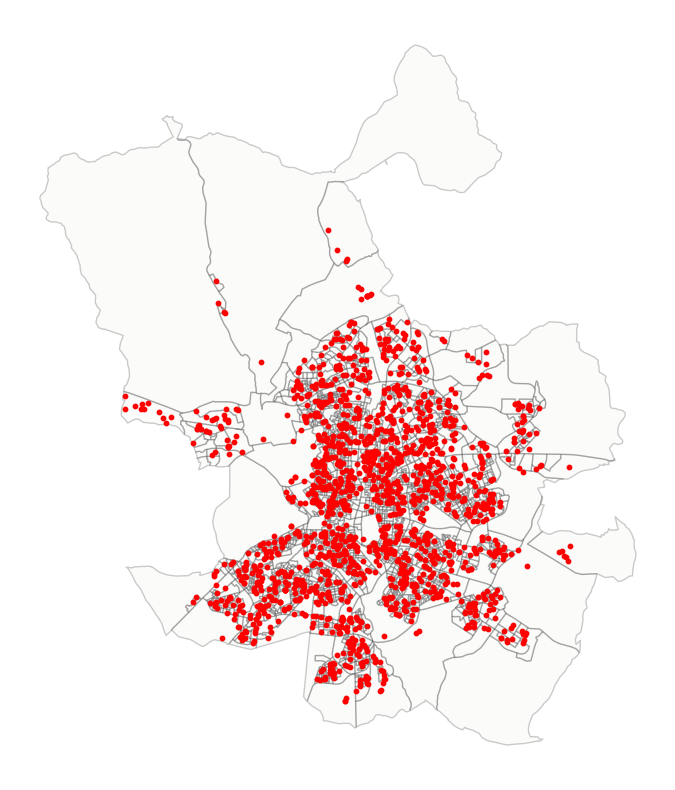

In [390]:
#Spatial joins

joined_school = gpd.sjoin(points, cusecs, how='left', op='within')

fig, ax = plt.subplots(figsize=(10, 10))
cusecs.plot(ax=ax, color='#EDEBEA', edgecolor='black', alpha=0.2, label='Original Districts')
joined_school[~joined_school.CUSEC.isna()].plot(ax=ax, color='red', markersize=10)

ax.axis('off')

legend = ax.legend(prop={'size': 18}, bbox_to_anchor=(0.4, 0.95), markerscale=5 )
legend.set_frame_on(False)

plt.show()

In [391]:
with open('./data/geography/cusecs/comarca_with_random_points_distances_madrid.pkl', 'rb') as f:
    random_points = pickle.load(f)

In [392]:
cusecs=cusecs.merge(random_points[['CUSEC','random_points']],on='CUSEC',how='left')

In [393]:
#Madrid is utm30
points = points.to_crs('EPSG:32630')

In [394]:
# Function to calculate distance to the closest point
'''
def closest_distance_to_points_metro(point_list, points_df):
    point_coords = np.array([point.xy for point in point_list])
    points_metro_coords = np.array([point.xy for point in points_df['geometry']])

    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))
    #For each of the 10 points, find the shortest distance
    min_distances = [min(point) for point in all_distances]
 
    #Avg 
    return np.mean(min_distances)


# Apply the function
cusecs['neigh_closest_school'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points))

with open('./data/geography/cusecs/comarca_with_random_points_distances_madrid_school.pkl', 'wb') as f:
    pickle.dump(cusecs, f)
''' 

"\ndef closest_distance_to_points_metro(point_list, points_df):\n    point_coords = np.array([point.xy for point in point_list])\n    points_metro_coords = np.array([point.xy for point in points_df['geometry']])\n\n    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))\n    #For each of the 10 points, find the shortest distance\n    min_distances = [min(point) for point in all_distances]\n \n    #Avg \n    return np.mean(min_distances)\n\n\n# Apply the function\ncusecs['neigh_closest_school'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points))\n\nwith open('./data/geography/cusecs/comarca_with_random_points_distances_madrid_school.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n"

In [395]:
# We  got the mean distance to the closest stop
with open('./data/geography/cusecs/comarca_with_random_points_distances_madrid_school.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [396]:
cusecs=cusecs[['CUSEC','neigh_closest_school']].rename(columns={'CUSEC':'cusec'})

In [397]:
cusecs.cusec=cusecs.cusec.astype('int64')

In [398]:
comarca=comarca.merge(cusecs, on='cusec',  how='left')

### 8. Places of Worship

In [399]:
'''
worship=pd.read_csv('./data_madrid/lugares_culto/lugares_culto.csv',sep=';', encoding='latin-1')
#Get list of full address
worship['full_address']=worship['Nombre de la vía']+', '+worship['Número']+', '+worship['Población']+', '+'Spain'
#Use Google Mapsb
import googlemaps
API_KEY= some_key
map_client= googlemaps.Client(API_KEY)
'''

"\nworship=pd.read_csv('./data_madrid/lugares_culto/lugares_culto.csv',sep=';', encoding='latin-1')\n#Get list of full address\nworship['full_address']=worship['Nombre de la vía']+', '+worship['Número']+', '+worship['Población']+', '+'Spain'\n#Use Google Mapsb\nimport googlemaps\nAPI_KEY= some_key\nmap_client= googlemaps.Client(API_KEY)\n"

In [400]:
'''
resolution=[]
import time
for place in worship.full_address.tolist():
    try:
        response= map_client.geocode(place)
        lat=response[0]['geometry']['location']['lat']
        lon=response[0]['geometry']['location']['lng']
        location=[lat,lon]
        print(location)
        resolution.append(location)
        time.sleep(2)
    except:
        resolution.append([None, None])
        print('Not found')
'''

"\nresolution=[]\nimport time\nfor place in worship.full_address.tolist():\n    try:\n        response= map_client.geocode(place)\n        lat=response[0]['geometry']['location']['lat']\n        lon=response[0]['geometry']['location']['lng']\n        location=[lat,lon]\n        print(location)\n        resolution.append(location)\n        time.sleep(2)\n    except:\n        resolution.append([None, None])\n        print('Not found')\n"

In [401]:
#worship['lat_long']=resolution
#worship['lat']=worship.lat_long.apply(lambda x:x[0])
#worship['long']=worship.lat_long.apply(lambda x:x[1])
#worship.to_csv('./data/lugares_culto/lugares_culto_googlemaps_madrid.csv',index=False) 

In [402]:
worship=pd.read_csv('./data/lugares_culto/lugares_culto_googlemaps_madrid.csv')

In [403]:
worship.tail(3)

,Nombre,Confesión,Denominación,Página web,E-mail,Número de registro,Número RER antiguo,Nombre de la vía,Número,Resto,Código postal,Distrito,Población,Provincia,Comunidad autónoma,Tamaño del municipio,full_address,lat_long,lat,long
569,Wicca Celtíbera,Otras Religiones,NaN,www.wiccaceltibera.wordpress.com,religion_wicca@hotmail.com,015163,2560-SG/A,Calle del Ferrocarril,33,5º Izq.,28045,02 Arganzuela,Madrid,Madrid,"Madrid, Comunidad de",3305408,"Calle del Ferrocarril, 33, Madrid, Spain","[40.4007143, -3.6974498]",40.400714,-3.697450
570,Yoido Full Gospel Madrid Church,Evangélicos,NaN,http://yfgmc.org/,moon0691@hanmail.net,024440,NaN,Calle de Ofelia Nieto,43,Bajo Local Izqu.,28039,09 Moncloa-Aravaca,Madrid,Madrid,"Madrid, Comunidad de",3305408,"Calle de Ofelia Nieto, 43, Madrid, Spain","[40.4606312, -3.7099964]",40.460631,-3.709996
571,Zona de Madrid de la Iglesia Evangélica Filade...,Evangélicos,NaN,NaN,NaN,022590,NaN,Avenida Orcasur,22,NaN,28041,12 Usera,Madrid,Madrid,"Madrid, Comunidad de",3305408,"Avenida Orcasur, 22, Madrid, Spain","[40.367711, -3.7016699]",40.367711,-3.701670


In [404]:
#Read map
cusecs = gpd.read_file('./data/geography/cusecs/comarca_reduced_madrid.shp')

In [405]:
cristianos = [
    "Evangélicos",
    "Testigos de Jehová",
    "Adventistas",
    "Iglesia de Jesucristo de los Santos de los Últimos Días",
    "Comunión Anglicana",
    "Otras Conf. Cristianas",
    "Ciencia cristiana"
]
worship_chr=worship[worship.Confesión.isin(cristianos)]
worship_mus=worship[worship.Confesión.isin(['Musulmanes'])]
worship_bud=worship[worship.Confesión.isin(['Budistas'])]
worship_ort=worship[worship.Confesión.isin(['Ortodoxos'])]

In [406]:
#Create coordinates
points_chr = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_chr['long'], worship_chr['lat'])).set_crs(epsg=4326)
points_mus = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_mus['long'], worship_mus['lat'])).set_crs(epsg=4326)
points_bud = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_bud['long'], worship_bud['lat'])).set_crs(epsg=4326)
points_ort = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_ort['long'], worship_ort['lat'])).set_crs(epsg=4326)

In [407]:
# Set CRS that is aligned with meters scale
cusecs = cusecs.set_crs(epsg=4326)
cusecs_buffered = cusecs.to_crs("EPSG:32630")
cusecs_buffered.geometry = cusecs_buffered.geometry.buffer(300, 6)

In [408]:
cusecs_buffered = cusecs_buffered.to_crs("EPSG:4326")

<Axes: >

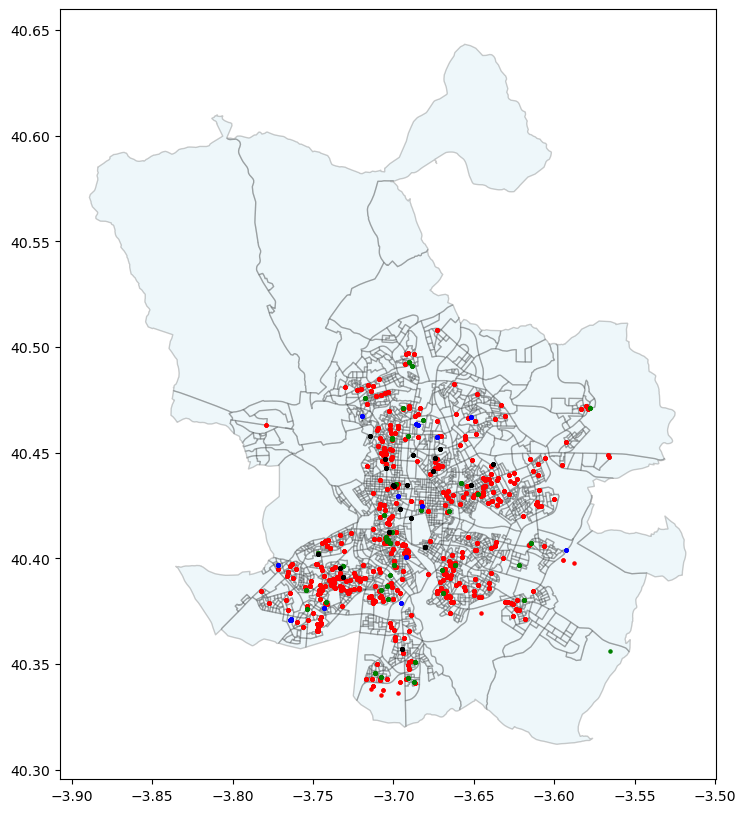

In [409]:
fig, ax = plt.subplots(figsize=(10, 10))
cusecs.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.2, label='Original Districts')
#cusecs_buffered.plot(ax=ax, color='orange', edgecolor='black', alpha=0.3, label='Buffered Districts')
#Plot Christian
joined = gpd.sjoin(points_chr, cusecs_buffered, how='left', op='within')
joined[~joined.CUSEC.isna()].plot(ax=ax, color='red', markersize=5, label='Points')
#Plot Muslim
joined = gpd.sjoin(points_mus, cusecs_buffered, how='left', op='within')
joined[~joined.CUSEC.isna()].plot(ax=ax, color='green', markersize=5, label='Points')
#Plot Budhist
joined = gpd.sjoin(points_bud, cusecs_buffered, how='left', op='within')
joined[~joined.CUSEC.isna()].plot(ax=ax, color='black', markersize=5, label='Points')
#Plot Ortodox
joined = gpd.sjoin(points_ort, cusecs_buffered, how='left', op='within')
joined[~joined.CUSEC.isna()].plot(ax=ax, color='blue', markersize=5, label='Points')

In [410]:
# We generated 10 points for each cusec, now load it
import pickle
with open('./data/geography/cusecs/comarca_with_random_points_madrid.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [411]:
points_chr = points_chr.to_crs('EPSG:32630')
points_mus = points_mus.to_crs('EPSG:32630')
points_bud = points_bud.to_crs('EPSG:32630')
points_ort = points_ort.to_crs('EPSG:32630')

In [412]:
points_chr=points_chr[~points_chr.is_empty]
points_mus=points_mus[~points_mus.is_empty]
points_bud=points_bud[~points_bud.is_empty]
points_ort=points_ort[~points_ort.is_empty]

In [413]:
# Function to calculate distance to the closest point
def closest_distance_to_points_metro(point_list, points_df):
    point_coords = np.array([point.xy for point in point_list])
    points_metro_coords = np.array([point.xy for point in points_df['geometry']])

    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))
    #For each of the 10 points, find the shortest distance
    min_distances = [min(point) for point in all_distances]

    #Avg
    return np.mean(min_distances)

In [414]:
# Apply the function
cusecs['neigh_closest_worsh_christ'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_chr))
cusecs['neigh_closest_worsh_bud'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_bud))
cusecs['neigh_closest_worsh_ort'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_ort))
cusecs['neigh_closest_worsh_mus'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_mus))

In [415]:
cusecs=cusecs.rename(columns={'CUSEC':'cusec'})

In [416]:
cusecs.cusec=cusecs.cusec.astype('int64')

In [417]:
comarca=comarca.merge(cusecs[['cusec','neigh_closest_worsh_christ', 'neigh_closest_worsh_bud', 'neigh_closest_worsh_ort', 'neigh_closest_worsh_mus']],
                      on='cusec',how='left')

In [418]:
comarca.head(5)

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,housing_rent_median,housing_rent_m2_median,neigh_closest_metro,neigh_closest_bus,neigh_closest_train,neigh_closest_school,neigh_closest_worsh_christ,neigh_closest_worsh_bud,neigh_closest_worsh_ort,neigh_closest_worsh_mus
0,2021,2807901001,Italia,18,1167,2807901001,28079,1,1,79,...,1000.0,14.472955,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481
1,2021,2807901001,Marruecos,9,1167,2807901001,28079,1,1,79,...,1000.0,14.472955,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481
2,2021,2807901001,Ecuador,11,1167,2807901001,28079,1,1,79,...,1000.0,14.472955,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481
3,2021,2807901001,Perú,13,1167,2807901001,28079,1,1,79,...,1000.0,14.472955,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481
4,2021,2807901001,China,16,1167,2807901001,28079,1,1,79,...,1000.0,14.472955,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481


### 9. Driving Distance to Center

In [419]:
'''
#Use Google Mapsb
API_KEY= some_key
map_client= googlemaps.Client(API_KEY)

# We generated 10 points for each cusec, now load it
with open('./data/geography/cusecs/comarca_with_random_points_madrid.pkl', 'rb') as f:
    cusecs = pickle.load(f)

from shapely.ops import transform
# Define a function to reproject a single point
def reproject_point(point, from_crs, to_crs):
    project = partial(pyproj.transform, pyproj.Proj(init=from_crs), pyproj.Proj(init=to_crs))
    return transform(project, point)

# Reproject the 'random_points' column to EPSG:4326
from_crs = 'EPSG:32630'  # replace with the actual CRS of your 'random_points' column
to_crs = 'EPSG:4326'
cusecs['random_points'] = cusecs['random_points'].apply(lambda points: [reproject_point(Point(point), from_crs, to_crs) for point in points])
'''

"\n#Use Google Mapsb\nAPI_KEY= some_key\nmap_client= googlemaps.Client(API_KEY)\n\n# We generated 10 points for each cusec, now load it\nwith open('./data/geography/cusecs/comarca_with_random_points_madrid.pkl', 'rb') as f:\n    cusecs = pickle.load(f)\n\nfrom shapely.ops import transform\n# Define a function to reproject a single point\ndef reproject_point(point, from_crs, to_crs):\n    project = partial(pyproj.transform, pyproj.Proj(init=from_crs), pyproj.Proj(init=to_crs))\n    return transform(project, point)\n\n# Reproject the 'random_points' column to EPSG:4326\nfrom_crs = 'EPSG:32630'  # replace with the actual CRS of your 'random_points' column\nto_crs = 'EPSG:4326'\ncusecs['random_points'] = cusecs['random_points'].apply(lambda points: [reproject_point(Point(point), from_crs, to_crs) for point in points])\n"

In [420]:
'''
#Use Google Maps Directions to get distances and driving time
import random
import time

result=[]
for i,row in cusecs.iterrows():
        points=row.random_points
        ###Only 5 out of 10
        points=random.sample(points, 5)
        row_results=[]
        for pip in points:
            ran_point=[pip.y,pip.x]
            print(ran_point)
            try:
                response= map_client.directions(
                    origin=ran_point,
                    #Puerta del sol
                    destination=[40.416936, -3.703413],
                    mode='driving',
                    )
                dist_m=response[0]['legs'][0]['distance']['value']
                dur_sec=response[0]['legs'][0]['duration']['value']
                driving=[dist_m,dur_sec]
                print(driving)
                row_results.append(driving)
                time.sleep(1)
            except:
                row_results.append([None, None])
        result.append(row_results)
'''

"\n#Use Google Maps Directions to get distances and driving time\nimport random\nimport time\n\nresult=[]\nfor i,row in cusecs.iterrows():\n        points=row.random_points\n        ###Only 5 out of 10\n        points=random.sample(points, 5)\n        row_results=[]\n        for pip in points:\n            ran_point=[pip.y,pip.x]\n            print(ran_point)\n            try:\n                response= map_client.directions(\n                    origin=ran_point,\n                    #Puerta del sol\n                    destination=[40.416936, -3.703413],\n                    mode='driving',\n                    )\n                dist_m=response[0]['legs'][0]['distance']['value']\n                dur_sec=response[0]['legs'][0]['duration']['value']\n                driving=[dist_m,dur_sec]\n                print(driving)\n                row_results.append(driving)\n                time.sleep(1)\n            except:\n                row_results.append([None, None])\n        result.app

In [421]:
'''
cusecs['driving']=result
with open('./data/geography/cusecs/comarca_with_driving_distances_madrid.pkl', 'wb') as f:
    pickle.dump(cusecs, f)
'''

"\ncusecs['driving']=result\nwith open('./data/geography/cusecs/comarca_with_driving_distances_madrid.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n"

In [422]:
with open('./data/geography/cusecs/comarca_with_driving_distances_madrid.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [423]:
cusecs['neigh_center_dist_m'] = cusecs['driving'].apply(lambda x: sum(i[0] for i in x if i[0] is not None) / len([i[0] for i in x if i[0] is not None]))
cusecs['neigh_center_dist_sec'] = cusecs['driving'].apply(lambda x: sum(i[1] for i in x if i[1] is not None) / len([i[1] for i in x if i[1] is not None]))

In [424]:
cusecs.CUSEC=cusecs.CUSEC.astype('int64')

In [425]:
comarca=comarca.merge(cusecs[['CUSEC','neigh_center_dist_m','neigh_center_dist_sec']].rename(columns={'CUSEC':'cusec'}),how='left',on='cusec')

In [426]:
comarca

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,neigh_closest_metro,neigh_closest_bus,neigh_closest_train,neigh_closest_school,neigh_closest_worsh_christ,neigh_closest_worsh_bud,neigh_closest_worsh_ort,neigh_closest_worsh_mus,neigh_center_dist_m,neigh_center_dist_sec
0,2021,2807901001,Italia,18,1167,2807901001,28079,1,1,79,...,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481,2057.8,523.4
1,2021,2807901001,Marruecos,9,1167,2807901001,28079,1,1,79,...,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481,2057.8,523.4
2,2021,2807901001,Ecuador,11,1167,2807901001,28079,1,1,79,...,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481,2057.8,523.4
3,2021,2807901001,Perú,13,1167,2807901001,28079,1,1,79,...,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481,2057.8,523.4
4,2021,2807901001,China,16,1167,2807901001,28079,1,1,79,...,481.333522,155.631306,527.427829,327.068106,502.641419,1343.973299,1993.303165,875.994481,2057.8,523.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12150,2021,2807921033,Italia,8,2742,2807921033,28079,33,21,79,...,1197.266816,451.532306,955.393558,638.474245,1943.112938,5327.522298,4530.139792,2717.633900,24303.4,1679.2
12151,2021,2807921033,Marruecos,43,2742,2807921033,28079,33,21,79,...,1197.266816,451.532306,955.393558,638.474245,1943.112938,5327.522298,4530.139792,2717.633900,24303.4,1679.2
12152,2021,2807921033,Ecuador,51,2742,2807921033,28079,33,21,79,...,1197.266816,451.532306,955.393558,638.474245,1943.112938,5327.522298,4530.139792,2717.633900,24303.4,1679.2
12153,2021,2807921033,Perú,23,2742,2807921033,28079,33,21,79,...,1197.266816,451.532306,955.393558,638.474245,1943.112938,5327.522298,4530.139792,2717.633900,24303.4,1679.2


### 10. Catastral Data

In [427]:
#District level catastral data
cat = pd.read_csv('./data_madrid/catastro/catastro_distritos.csv',skiprows=5,encoding='latin-1', thousands='.')

In [428]:
cat['district'] = cat['Unnamed: 0'].str.split('-').str[0]

In [429]:
cat=cat[['district','Aparcamiento','Comercial','Industrial','Oficinas']]
cat.columns=['district','neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']

In [430]:
cat=cat.iloc[:-4,:]
cat.district=cat.district.astype(int)

In [431]:
cat=cat.replace({'..':np.nan})

Make these numbers per km2

In [432]:
cat

,district,neigh_parking_per_area,neigh_commerc_per_area,neigh_indust_per_area,neigh_office_per_area
0,280011,2,NaN,68,NaN
1,2800199,NaN,NaN,1,NaN
2,280020,NaN,2,1,NaN
3,280021,595,55,676,81
4,2800299,18,3,NaN,NaN
...,...,...,...,...,...
418,2890199,1,NaN,2,NaN
419,289021,30,1,272,6
420,2890299,NaN,NaN,NaN,NaN
421,289031,8.487,1.273,161,976


In [433]:
comarca['district']=(comarca['CUMUN'].astype(str) + comarca['CDIS'].astype(str)).astype(int)

In [434]:
#Find total area in district
district_areas=comarca[['district','area']].drop_duplicates().groupby('district').area.sum().reset_index()

In [435]:
#Make it square kilomenter
district_areas['area']=district_areas['area']/1000000

In [436]:
district_areas

,district,area
0,280791,5.210524
1,280792,6.560349
2,280793,5.368031
3,280794,5.399251
4,280795,9.178029
5,280796,5.372740
6,280797,4.680917
7,280798,25.375900
8,280799,42.989647
9,2807910,25.424977


In [437]:
cat=cat.merge(district_areas, on='district', how='left' )
cat=cat[~cat.area.isna()]

In [438]:
cat[['neigh_parking_per_area', 'neigh_commerc_per_area',
       'neigh_indust_per_area', 'neigh_office_per_area']]= cat[['neigh_parking_per_area', 'neigh_commerc_per_area',
       'neigh_indust_per_area', 'neigh_office_per_area']].astype(str).replace('\.', '', regex=True).astype(int)

In [439]:
cat[['neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']]=cat[['neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']].div(cat.area, axis=0)

In [440]:
cat.head(10)

,district,neigh_parking_per_area,neigh_commerc_per_area,neigh_indust_per_area,neigh_office_per_area,area
187,280791,2503.778713,1819.778457,20.535361,588.808301,5.210524
188,2807910,845.428486,254.080857,15.378578,36.027564,25.424977
189,2807911,2025.744111,516.158433,111.976520,70.385241,14.065449
190,2807912,1268.892079,477.528925,43.247415,48.669479,7.746128
191,2807913,1297.208053,490.328075,46.166603,23.317141,14.967530
192,2807914,801.680373,323.229134,9.342830,40.649506,6.100935
193,2807915,2730.010531,637.244301,54.371187,130.683159,11.439883
194,2807916,1411.716922,121.107364,19.965955,58.185458,27.446721
195,2807917,733.399656,166.337044,82.970266,69.340145,20.175903
196,2807918,778.721419,82.052828,58.512737,23.413532,23.704241


In [441]:
comarca=comarca.merge(cat.drop('area',axis=1), on='district', how='left')

In [442]:
comarca.head()

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,neigh_closest_worsh_bud,neigh_closest_worsh_ort,neigh_closest_worsh_mus,neigh_center_dist_m,neigh_center_dist_sec,district,neigh_parking_per_area,neigh_commerc_per_area,neigh_indust_per_area,neigh_office_per_area
0,2021,2807901001,Italia,18,1167,2807901001,28079,1,1,79,...,1343.973299,1993.303165,875.994481,2057.8,523.4,280791,2503.778713,1819.778457,20.535361,588.808301
1,2021,2807901001,Marruecos,9,1167,2807901001,28079,1,1,79,...,1343.973299,1993.303165,875.994481,2057.8,523.4,280791,2503.778713,1819.778457,20.535361,588.808301
2,2021,2807901001,Ecuador,11,1167,2807901001,28079,1,1,79,...,1343.973299,1993.303165,875.994481,2057.8,523.4,280791,2503.778713,1819.778457,20.535361,588.808301
3,2021,2807901001,Perú,13,1167,2807901001,28079,1,1,79,...,1343.973299,1993.303165,875.994481,2057.8,523.4,280791,2503.778713,1819.778457,20.535361,588.808301
4,2021,2807901001,China,16,1167,2807901001,28079,1,1,79,...,1343.973299,1993.303165,875.994481,2057.8,523.4,280791,2503.778713,1819.778457,20.535361,588.808301


### 11. Total Area

In [443]:
comarca['neigh_area']=comarca.area/1000000

## Final touches

In [444]:
comarca=comarca.drop(['year','CUSEC','CMUN','CSEC','CDIS','CMUN','CUMUN','CPRO','CCA','CUDIS','CLAU2','NPRO','NCA', 'CNUT0',
       'CNUT1', 'CNUT2', 'CNUT3', 'NMUN', 'area'],axis=1)

In [446]:
cusec_level_data=comarca[['cusec', 'cob','population','census_total_pop',
                          
        ##Demographic variables
       'demog_avg_income',  'demog_mean_age','demog_hh_5p+',
        ## Housing variables
       'housing_rented', 'housing_constr_bef_1940',
       'housing_constr_aft_2000', 'housing_floor_1', 'housing_floor_7_plus',
       'housing_m2_und_60', 'housing_m2_ovr_120',
       'housing_rent_m2_median',  
        ## Neighborhood variables
      'neigh_closest_school',                
      'neigh_closest_metro', 'neigh_closest_bus','neigh_closest_train', 
        'neigh_closest_worsh_christ','neigh_closest_worsh_mus', 
        'neigh_center_dist_m',
       'neigh_commerc_per_area', 'neigh_indust_per_area',
       'neigh_office_per_area',
        'neigh_area'        ]].drop_duplicates()

In [447]:
#No missing values
cusec_level_data.isna().sum()

cusec                         0
cob                           0
population                    0
census_total_pop              0
demog_avg_income              0
demog_mean_age                0
demog_hh_5p+                  0
housing_rented                0
housing_constr_bef_1940       0
housing_constr_aft_2000       0
housing_floor_1               0
housing_floor_7_plus          0
housing_m2_und_60             0
housing_m2_ovr_120            0
housing_rent_m2_median        0
neigh_closest_school          0
neigh_closest_metro           0
neigh_closest_bus             0
neigh_closest_train           0
neigh_closest_worsh_christ    0
neigh_closest_worsh_mus       0
neigh_center_dist_m           0
neigh_commerc_per_area        0
neigh_indust_per_area         0
neigh_office_per_area         0
neigh_area                    0
dtype: int64

In [453]:
cusec_level_data[['housing_constr_bef_1940',
'housing_constr_aft_2000',   
'housing_floor_1' ,               
'housing_floor_7_plus' ,          
'housing_m2_und_60'   ,           
'housing_m2_ovr_120' ]  ]  =cusec_level_data[['housing_constr_bef_1940',
'housing_constr_aft_2000',   
'housing_floor_1' ,               
'housing_floor_7_plus' ,          
'housing_m2_und_60'   ,           
'housing_m2_ovr_120' ]  ].astype('float64')        

In [454]:
cusec_level_data.drop('cusec',axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
population,12155.0,19.036364,26.896146,0.000000,4.000000,9.000000,23.000000,343.000000
census_total_pop,12155.0,1350.248046,487.265121,561.000000,1001.000000,1251.000000,1585.000000,5054.000000
demog_avg_income,12155.0,17126.295352,6373.935436,6625.000000,11764.000000,15877.000000,21346.000000,32039.000000
demog_mean_age,12155.0,45.109857,4.039345,27.831300,43.096900,45.390900,47.621300,57.844000
demog_hh_5p+,12155.0,0.078097,0.038317,0.011194,0.052632,0.070205,0.094059,0.397032
housing_rented,12155.0,0.202739,0.068424,0.040123,0.151475,0.203593,0.252722,0.500000
housing_constr_bef_1940,12155.0,0.104662,0.167604,0.001404,0.007597,0.015162,0.139294,0.712200
housing_constr_aft_2000,12155.0,0.102991,0.089990,0.017734,0.042157,0.062655,0.147518,0.486891
housing_floor_1,12155.0,0.010860,0.010759,0.000173,0.005362,0.009406,0.013409,0.050186
housing_floor_7_plus,12155.0,0.409486,0.179781,0.131192,0.262654,0.362910,0.559839,0.831961


In [456]:
cusec_level_data=cusec_level_data.drop('neigh_commerc_per_area',axis=1)

## Adding Indeces

In [457]:
cusec_level_data=cusec_level_data.sort_values(['cusec','cob'],ascending=True)

In [458]:
cusec_level_data

,cusec,cob,population,census_total_pop,demog_avg_income,demog_mean_age,demog_hh_5p+,housing_rented,housing_constr_bef_1940,housing_constr_aft_2000,...,neigh_closest_school,neigh_closest_metro,neigh_closest_bus,neigh_closest_train,neigh_closest_worsh_christ,neigh_closest_worsh_mus,neigh_center_dist_m,neigh_indust_per_area,neigh_office_per_area,neigh_area
4,2807901001,China,16,1167,24134.0,47.7131,0.031915,0.259409,0.712200,0.042157,...,327.068106,481.333522,155.631306,527.427829,502.641419,875.994481,2057.8,20.535361,588.808301,0.657933
2,2807901001,Ecuador,11,1167,24134.0,47.7131,0.031915,0.259409,0.712200,0.042157,...,327.068106,481.333522,155.631306,527.427829,502.641419,875.994481,2057.8,20.535361,588.808301,0.657933
0,2807901001,Italia,18,1167,24134.0,47.7131,0.031915,0.259409,0.712200,0.042157,...,327.068106,481.333522,155.631306,527.427829,502.641419,875.994481,2057.8,20.535361,588.808301,0.657933
1,2807901001,Marruecos,9,1167,24134.0,47.7131,0.031915,0.259409,0.712200,0.042157,...,327.068106,481.333522,155.631306,527.427829,502.641419,875.994481,2057.8,20.535361,588.808301,0.657933
3,2807901001,Perú,13,1167,24134.0,47.7131,0.031915,0.259409,0.712200,0.042157,...,327.068106,481.333522,155.631306,527.427829,502.641419,875.994481,2057.8,20.535361,588.808301,0.657933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12154,2807921033,China,5,2742,12877.0,32.2923,0.075661,0.226879,0.009355,0.205057,...,638.474245,1197.266816,451.532306,955.393558,1943.112938,2717.633900,24303.4,11.077272,28.170016,5.170477
12152,2807921033,Ecuador,51,2742,12877.0,32.2923,0.075661,0.226879,0.009355,0.205057,...,638.474245,1197.266816,451.532306,955.393558,1943.112938,2717.633900,24303.4,11.077272,28.170016,5.170477
12150,2807921033,Italia,8,2742,12877.0,32.2923,0.075661,0.226879,0.009355,0.205057,...,638.474245,1197.266816,451.532306,955.393558,1943.112938,2717.633900,24303.4,11.077272,28.170016,5.170477
12151,2807921033,Marruecos,43,2742,12877.0,32.2923,0.075661,0.226879,0.009355,0.205057,...,638.474245,1197.266816,451.532306,955.393558,1943.112938,2717.633900,24303.4,11.077272,28.170016,5.170477


In [459]:
#Assign index to cusec
text_to_index = {text: index +1 for index, text in enumerate(cusec_level_data['cusec'].unique())}
cusec_level_data['cusec_idx'] = cusec_level_data['cusec'].map(text_to_index)

In [460]:
#Assign index to cob
text_to_index = {text: index +1 for index, text in enumerate(cusec_level_data['cob'].unique())}
cusec_level_data['cob_idx'] = cusec_level_data['cob'].map(text_to_index)

In [461]:
cusec_level_data=cusec_level_data[['cusec', 'cusec_idx', 'cob',  'cob_idx', 'population', 'census_total_pop', 'demog_avg_income',
       'demog_mean_age', 'demog_hh_5p+', 'housing_rented',
       'housing_constr_bef_1940', 'housing_constr_aft_2000', 'housing_floor_1',
       'housing_floor_7_plus', 'housing_m2_und_60', 'housing_m2_ovr_120',
       'housing_rent_m2_median', 'neigh_closest_school', 'neigh_closest_metro',
       'neigh_closest_bus', 'neigh_closest_train',
       'neigh_closest_worsh_christ', 'neigh_closest_worsh_mus',
       'neigh_center_dist_m', 'neigh_indust_per_area', 'neigh_office_per_area',
       'neigh_area']]

In [462]:
cusec_level_data[['cusec', 'cusec_idx']].drop_duplicates()

,cusec,cusec_idx
4,2807901001,1
9,2807901002,2
14,2807901003,3
19,2807901004,4
24,2807901006,5
...,...,...
12134,2807921029,2427
12139,2807921030,2428
12144,2807921031,2429
12149,2807921032,2430


In [463]:
cusec_level_data[['cob',  'cob_idx']].drop_duplicates()

,cob,cob_idx
4,China,1
2,Ecuador,2
0,Italia,3
1,Marruecos,4
3,Perú,5


## Final Export

In [464]:
cusec_level_data.to_csv('./intermediate_files/feature_matrix_madrid.csv',index=False)

## Adjacency Matrix

In [481]:
#Read map
gdf = gpd.read_file('./data/geography/cusecs/comarca_reduced_madrid.shp')

In [482]:
#Remove the ones that had no data in 2021
gdf = gdf[~gdf.CUSEC.isin(['2807908002','2807908004','2807908130','2807908129','2807909072','2807919001','2807918045','2807918057','2807919052','2807908001','2807908003','2807921015'])]

In [483]:
len(gdf)

2431

In [484]:
gdf=gdf.sort_values('CUSEC',ascending=True)
gdf=gdf.reset_index(drop=True)

In [485]:
sindex = gdf.sindex

In [487]:
# Initialize the adjacency matrix
n = len(gdf)
adjacency_matrix = np.zeros((n, n), dtype=int)

# Loop through each polygon
for i in range(n):
    # Find the neighbors of the current polygon
    neighbors = list(sindex.intersection(gdf.geometry[i].bounds))
    # Remove the current polygon from the list of neighbors
    neighbors.remove(i)
    # Update the adjacency matrix
    for neighbor in neighbors:
        adjacency_matrix[i][neighbor] = 1

# Print or use the adjacency matrix as needed
print(adjacency_matrix)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [488]:
adjacency_matrix=pd.DataFrame(adjacency_matrix,columns=gdf.CUSEC, index=gdf.CUSEC)
adjacency_matrix

CUSEC,2807901001,2807901002,2807901003,2807901004,2807901006,2807901007,2807901008,2807901009,2807901011,2807901012,...,2807921023,2807921025,2807921026,2807921027,2807921028,2807921029,2807921030,2807921031,2807921032,2807921033
CUSEC,,,,,,,,,,,,,,,,,,,,,
2807901001,0,1,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2807901002,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2807901003,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2807901004,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2807901006,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807921029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,1
2807921030,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,1
2807921031,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1


In [489]:
#Assign index to cusec
text_to_index = {text: index +1 for index, text in enumerate(adjacency_matrix.index.unique())}
adjacency_matrix.index = adjacency_matrix.index.map(text_to_index)
adjacency_matrix.columns = adjacency_matrix.columns.map(text_to_index)

In [490]:
adjacency_matrix

CUSEC,1,2,3,4,5,6,7,8,9,10,...,2422,2423,2424,2425,2426,2427,2428,2429,2430,2431
CUSEC,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,1
2428,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,1
2429,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1


In [491]:
# Initialize lists to store neighboring census tracts and their counts
neighboring_cusecs = []
cusec_neighbor_counts = []

# Iterate through the adjacency matrix
for cusec_id, row in adjacency_matrix.iterrows():
    # Extract neighboring cusecs for the current cusec
    neighbors = list(row.index[row == 1])
    # Append the neighbors to the neighboring_cusecs list
    neighboring_cusecs.extend(neighbors)
    # Append the count of neighbors for the current cusec
    cusec_neighbor_counts.append(len(neighbors))

# Print or use the lists as needed
print("Neighboring cusecs:", neighboring_cusecs)
print("Cusec neighbor counts:", cusec_neighbor_counts)

Neighboring cusecs: [2, 4, 5, 6, 8, 14, 15, 100, 112, 113, 114, 961, 962, 969, 970, 971, 972, 973, 1036, 1057, 1061, 1, 3, 4, 99, 100, 973, 2, 4, 5, 100, 101, 102, 103, 105, 111, 1, 2, 3, 5, 1, 3, 4, 6, 105, 109, 110, 111, 1, 5, 7, 8, 109, 110, 111, 6, 8, 9, 109, 110, 1, 6, 7, 9, 10, 13, 14, 15, 22, 109, 7, 8, 10, 11, 12, 13, 14, 22, 109, 8, 9, 11, 12, 21, 22, 23, 109, 9, 10, 12, 13, 17, 18, 20, 21, 22, 28, 9, 10, 11, 13, 17, 20, 8, 9, 11, 12, 14, 15, 16, 17, 1, 8, 9, 13, 15, 1, 8, 13, 14, 16, 17, 18, 112, 117, 119, 120, 13, 15, 17, 18, 117, 119, 120, 203, 11, 12, 13, 15, 16, 18, 19, 119, 11, 15, 16, 17, 19, 20, 124, 125, 203, 17, 18, 20, 28, 29, 124, 125, 11, 12, 18, 19, 21, 28, 29, 10, 11, 20, 22, 26, 27, 28, 30, 8, 9, 10, 11, 21, 23, 24, 25, 26, 28, 31, 40, 41, 43, 61, 10, 22, 24, 41, 61, 108, 109, 22, 23, 25, 41, 54, 61, 62, 22, 24, 26, 31, 40, 41, 43, 61, 21, 22, 25, 27, 28, 30, 31, 21, 26, 28, 29, 30, 31, 32, 33, 43, 11, 19, 20, 21, 22, 26, 27, 29, 30, 33, 19, 20, 27, 28, 30, 33,

In [492]:
# Save neighboring_cusecs to a text file
with open('./intermediate_files/icar_adj_madrid.txt', 'w') as f:
    for item in neighboring_cusecs:
        f.write('%s\n' % item)

# Save cusec_neighbor_counts to a text file
with open('./intermediate_files/icar_num_madrid.txt', 'w') as f:
    for item in cusec_neighbor_counts:
        f.write('%s\n' % item)